In [70]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [3]:
data = pd.read_csv(csv_path)
data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [4]:
data.index = pd.to_datetime(data["Date Time"],format = "%d.%m.%Y %H:%M:%S")
data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,,
2009-01-01 00:10:00,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


## We are creating a Forecast Problem to Supervised problem

We do that by the following:
Actaully the input to the RNN or LSTM should be a Sequence'
We have a function called "tf.keras.preprocessing.sequence.TimeseriesGenerator" for generationg this type of sequence 
The sequnece should be as follows


X Y


[[[1],[2],[3],[4],[5]]] [6]


[[[2],[3],[4],[5],[6]]] [7]


[[[3],[4],[5],[6],[7]]] [8]

So we are using the data from timestamp 1 to 5 to predict output at 6th timestamp
I.e., the data from 1 to 5 time stamp will be the Independendt variable(X) and 6th time stamp will be Target Varialbe(Y)

We process the data into sequence Manually

In [5]:
def df_as_sequence_input(data,window_size = 5):
    data_numpy = data.to_numpy()
    x = []
    y = []
    for i in range(len(data_numpy) - window_size):
        row = [[a] for a in data_numpy[i:i+window_size]]
        x.append(row)
        label = data_numpy[i+1]
        y.append(label)
    return np.array(x),np.array(y)
            

In [6]:
data_numpy = data.to_numpy()
data_numpy[1]

array(['01.01.2009 00:20:00', 996.57, -8.41, 265.01, -9.28, 93.4, 3.23,
       3.02, 0.21, 1.89, 3.03, 1309.8, 0.72, 1.5, 136.1], dtype=object)

<Axes: xlabel='Date Time'>

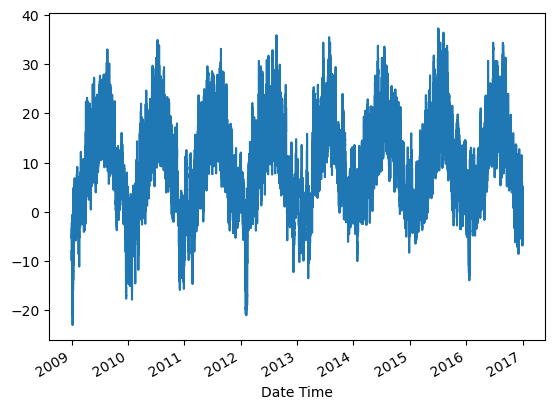

In [7]:
temp_data = data['T (degC)']
temp_data.plot()

In [8]:
x,y = df_as_sequence_input(temp_data)
x.shape,y.shape

((420546, 5, 1), (420546,))

In [9]:
(x.shape[0] * 0.1 )

42054.600000000006

In [10]:
def train_test_val(x,y,train_ratio,test_ratio,val_ratio):
    
    train_size = int(x.shape[0] * train_ratio)
    test_size =  int(x.shape[0] * test_ratio)
    val_size =  int(x.shape[0] * val_ratio)
    
    x_train,y_train = x[:294382] , y[:294382]
    x_val,y_val = x[294382:3018491],y[294382:3018491]
    x_test,y_test = x[3018491:],y[3018491:]
    
    return x_train,y_train,x_test,y_test,x_val,y_val


train_ratio = 0.7
test_ratio = 0.1
val_ratio = 1 - train_ratio - test_ratio

x_train,y_train,x_test,y_test,x_val,y_val = train_test_val(x,y,train_ratio,test_ratio,val_ratio)

In [11]:
x_train.shape

(294382, 5, 1)

In [38]:
model = Sequential([
    InputLayer(shape=(5,1)),
    LSTM(units=64),
    Dense(units=8,activation="relu"),
    Dense(units = 1, activation="linear")
])

In [54]:
check_points = ModelCheckpoint("model.keras",monitor="val_loss",save_best_only=True)
model.compile(optimizer = Adam(learning_rate=0.001),loss=MeanSquaredError(),metrics = [RootMeanSquaredError()])

In [55]:
model.fit(x = x_train,y = y_train, validation_data = (x_val,y_val),epochs = 25,verbose = 1,callbacks = check_points)

Epoch 1/25
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - loss: 0.0027 - root_mean_squared_error: 0.0495 - val_loss: 5.0743e-04 - val_root_mean_squared_error: 0.0225
Epoch 2/25
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - loss: 0.0018 - root_mean_squared_error: 0.0427 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0356
Epoch 3/25
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - loss: 0.0016 - root_mean_squared_error: 0.0395 - val_loss: 3.3598e-04 - val_root_mean_squared_error: 0.0183
Epoch 4/25
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - loss: 0.0013 - root_mean_squared_error: 0.0367 - val_loss: 4.7331e-04 - val_root_mean_squared_error: 0.0218
Epoch 5/25
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - loss: 0.0012 - root_mean_squared_error: 0.0348 - val_loss: 4.5506e-04 - val_root_mean_squared_error: 0.0213
Epoch 6/25
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - loss: 0.0012 - root_mean_squared_error: 0.0343 - val_loss: 5.3423e-04 - val_root_mean_squared_error: 0.0231
Epoch 7/25
920

In [57]:
model.save("model.keras")

In [59]:
train_pred = model.predict(x_train).flatten()
train_res = pd.DataFrame(data = {"pedicted_values" : train_pred,"actual_value" : y_train})
train_res

9200/9200 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step


,pedicted_values,actual_value
0,-8.396479,-8.41
1,-8.497149,-8.51
2,-8.298621,-8.31
3,-8.253706,-8.27
4,-8.036310,-8.05
...,...,...
294377,14.772629,14.78
294378,14.909611,14.92
294379,14.560827,14.57
294380,14.519391,14.53


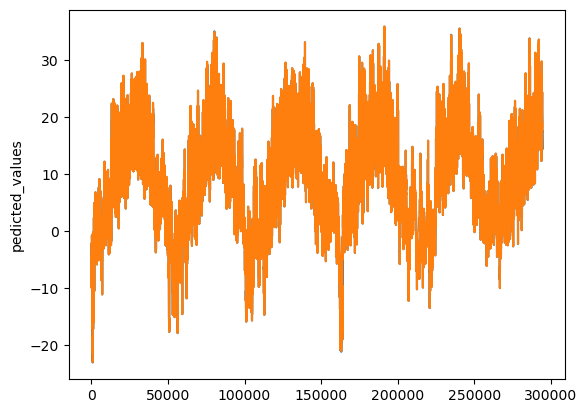

In [68]:
sns.lineplot(data=train_res["pedicted_values"])
sns.lineplot(data = train_res["actual_value"])
plt.show()

# 1-D CNN Model

In [12]:
x_train.shape

(294382, 5, 1)

In [13]:
cnn_model = Sequential([
    InputLayer(shape=(5,1)),
    Conv1D(filters = 64,kernel_size=2,strides=1),
    Flatten(),
    Dense(64,activation="relu"),
    Dense(1,activation="linear")    
])

In [14]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 4, 64)          │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,705 (65.25 KB)

 Trainable params: 16,705 (65.25 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
check_points = ModelCheckpoint("cnn_model.keras",monitor="val_loss",save_best_only=True)
cnn_model.compile(optimizer = Adam(learning_rate=0.001),loss=MeanSquaredError(),metrics = [RootMeanSquaredError()])
cnn_model.fit(x = x_train,y = y_train,epochs = 25,validation_data = (x_val,y_val))

Epoch 1/25
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 0.5918 - root_mean_squared_error: 0.5328 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1058
Epoch 2/25
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - loss: 0.0037 - root_mean_squared_error: 0.0596 - val_loss: 1.6877e-04 - val_root_mean_squared_error: 0.0130
Epoch 3/25
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0019 - root_mean_squared_error: 0.0429 - val_loss: 5.9889e-06 - val_root_mean_squared_error: 0.0024
Epoch 4/25
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.0012 - root_mean_squared_error: 0.0340 - val_loss: 4.4920e-05 - val_root_mean_squared_error: 0.0067
Epoch 5/25
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 8.9804e-04 - root_mean_squared_error: 0.0297 - val_loss: 1.6788e-04 - val_root_mean_squared_error: 0.0130
Epoch 6/25
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - loss: 7.3068e-04 - root_mean_squared_error: 0.0269 - val_loss: 1.1953e-06 - val_root_mean_squared_error: 0.0011
Epoch 

9200/9200 ━━━━━━━━━━━━━━━━━━━━ 4s 466us/step


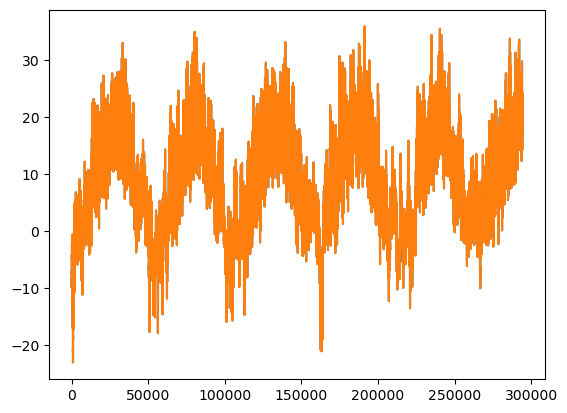

In [18]:
cnn_model_train_pred = cnn_model.predict(x_train).flatten()
cnn_model_pred = pd.DataFrame({"Predicted" : cnn_model_train_pred,"Actual" : y_train})

plt.plot(cnn_model_pred["Predicted"])
plt.plot(cnn_model_pred["Actual"])


In [19]:
cnn_model.save("cnn_model.keras")

# GRU Model (Gated Recuurent Units):

In [21]:
gru_model = Sequential([
    InputLayer(shape=(5,1)),
    GRU(units=64),
    Dense(units=64,activation="relu"),
    Dense(units=1,activation="linear")
])
gru_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,089 (66.75 KB)

 Trainable params: 17,089 (66.75 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
check_points3 = ModelCheckpoint("cnn_model.keras",monitor="val_loss",save_best_only=True)
gru_model.compile(optimizer = Adam(learning_rate=0.001),loss=MeanSquaredError(),metrics = [RootMeanSquaredError()])
gru_model.fit(x = x_train,y = y_train,epochs = 10,validation_data = (x_val,y_val),callbacks = check_points3)

Epoch 1/10
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 0.0168 - root_mean_squared_error: 0.1253 - val_loss: 0.0230 - val_root_mean_squared_error: 0.1517
Epoch 2/10
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - loss: 0.0061 - root_mean_squared_error: 0.0780 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0372
Epoch 3/10
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - loss: 0.0038 - root_mean_squared_error: 0.0613 - val_loss: 4.0850e-04 - val_root_mean_squared_error: 0.0202
Epoch 4/10
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 0.0024 - root_mean_squared_error: 0.0491 - val_loss: 8.3681e-04 - val_root_mean_squared_error: 0.0289
Epoch 5/10
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - loss: 0.0019 - root_mean_squared_error: 0.0431 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0427
Epoch 6/10
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - loss: 0.0016 - root_mean_squared_error: 0.0400 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0453
Epoch 7/10
9200/9200 ━━━━━

9200/9200 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step


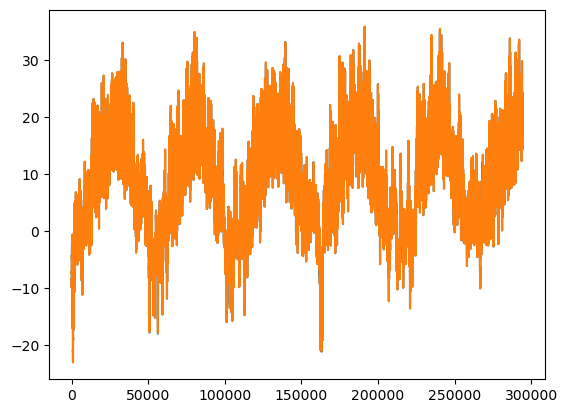

In [32]:
gru_model_train_pred = gru_model.predict(x_train).flatten()
gru_model_pred = pd.DataFrame({"Predicted" : gru_model_train_pred,"Actual" : y_train})

plt.plot(gru_model_pred["Predicted"])
plt.plot(gru_model_pred["Actual"])

In [28]:
y_train.max()

35.86

In [33]:
gru_model_pred

,Predicted,Actual
0,-8.414911,-8.41
1,-8.507156,-8.51
2,-8.322434,-8.31
3,-8.277115,-8.27
4,-8.045193,-8.05
...,...,...
294377,14.772901,14.78
294378,14.907852,14.92
294379,14.567780,14.57
294380,14.522044,14.53


In [82]:
temp_df = pd.DataFrame({"Temperature" : temp_data})
temp_df["seconds"] = temp_df.index.map(pd.Timestamp.timestamp)
temp_df.head()

,Temperature,seconds
Date Time,,
2009-01-01 00:10:00,-8.02,1.230769e+09
2009-01-01 00:20:00,-8.41,1.230769e+09
2009-01-01 00:30:00,-8.51,1.230770e+09
2009-01-01 00:40:00,-8.31,1.230770e+09
2009-01-01 00:50:00,-8.27,1.230771e+09


In [83]:
day = 24*60*60
year = (365.2425)*day
temp_df['Day sin'] = np.sin(temp_df["seconds"] * (2 * np.pi / day))
temp_df['Day cos'] = np.cos(temp_df["seconds"] * (2 * np.pi / day))
temp_df['Year sin'] = np.sin(temp_df["seconds"] * (2 * np.pi / year))
temp_df['Year cos'] = np.cos(temp_df["seconds"] * (2 * np.pi / year))

In [84]:
temp_df.head()

,Temperature,seconds,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,
2009-01-01 00:10:00,-8.02,1.230769e+09,0.043619,0.999048,0.009452,0.999955
2009-01-01 00:20:00,-8.41,1.230769e+09,0.087156,0.996195,0.009571,0.999954
2009-01-01 00:30:00,-8.51,1.230770e+09,0.130526,0.991445,0.009691,0.999953
2009-01-01 00:40:00,-8.31,1.230770e+09,0.173648,0.984808,0.009810,0.999952
2009-01-01 00:50:00,-8.27,1.230771e+09,0.216440,0.976296,0.009930,0.999951


In [85]:
temp_df.drop("seconds",axis = 1, inplace=True)
temp_df.head()

,Temperature,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,
2009-01-01 00:10:00,-8.02,0.043619,0.999048,0.009452,0.999955
2009-01-01 00:20:00,-8.41,0.087156,0.996195,0.009571,0.999954
2009-01-01 00:30:00,-8.51,0.130526,0.991445,0.009691,0.999953
2009-01-01 00:40:00,-8.31,0.173648,0.984808,0.009810,0.999952
2009-01-01 00:50:00,-8.27,0.216440,0.976296,0.009930,0.999951


In [86]:
b = pd.DataFrame(temp_df['Temperature'])
ss = StandardScaler()
a = ss.fit_transform(X=b)
temp_df["Temperature"] = a
temp_df.head()

,Temperature,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,
2009-01-01 00:10:00,-2.074013,0.043619,0.999048,0.009452,0.999955
2009-01-01 00:20:00,-2.120313,0.087156,0.996195,0.009571,0.999954
2009-01-01 00:30:00,-2.132184,0.130526,0.991445,0.009691,0.999953
2009-01-01 00:40:00,-2.108441,0.173648,0.984808,0.009810,0.999952
2009-01-01 00:50:00,-2.103692,0.216440,0.976296,0.009930,0.999951


In [99]:
def df_as_sequence_input2(data,window_size = 6):
    data_numpy = data.to_numpy()
    x = []
    y = []
    for i in range(len(data_numpy) - window_size):
        row = [a for a in data_numpy[i:i+window_size]]
        x.append(row)
        label = data_numpy[i+window_size]
        y.append(label[0])
    return np.array(x),np.array(y)
x2,y2 = df_as_sequence_input2(temp_df)


In [88]:
y2

array([-2.12031274, -2.1321845 , -2.10844099, ..., -1.60745297,
       -1.56827619, -1.58845817])

In [91]:
x2.shape, y2.shape

((420545, 6, 5), (420545,))

In [100]:
def train_test_val2(x,y,train_ratio,test_ratio,val_ratio):
    
    train_size = int(x.shape[0] * train_ratio)
    test_size =  int(x.shape[0] * test_ratio)
    val_size =  int(x.shape[0] * val_ratio)
    
    x_train,y_train = x[:294382] , y[:294382]
    x_val,y_val = x[294382:3018491],y[294382:3018491]
    x_test,y_test = x[3018491:],y[3018491:]
    
    return x_train,y_train,x_test,y_test,x_val,y_val


train_ratio = 0.7
test_ratio = 0.1
val_ratio = 1 - train_ratio - test_ratio

x_train2,y_train2,x_test2,y_test2,x_val2,y_val2 = train_test_val2(x2,y2,train_ratio,test_ratio,val_ratio)

In [101]:
x_train2.shape

(294382, 6, 5)

In [102]:
model4 = Sequential([
    InputLayer(shape=(6,5)),
    LSTM(units = 64),
    Dense(units=64,activation="relu"),
    Dense(units=1,activation = "linear")
])

In [103]:
model4.compile(optimizer = Adam(learning_rate=0.001),loss = MeanSquaredError() ,metrics = [RootMeanSquaredError()])
model4.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,145 (86.50 KB)

 Trainable params: 22,145 (86.50 KB)

 Non-trainable params: 0 (0.00 B)

In [95]:
model4.fit(x = x_train2, y = y_train2, validation_data= (x_val2,y_val2),epochs = 10)

Epoch 1/10
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 0.0125 - root_mean_squared_error: 0.0843 - val_loss: 3.6797e-04 - val_root_mean_squared_error: 0.0192
Epoch 2/10
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 3.0474e-04 - root_mean_squared_error: 0.0174 - val_loss: 1.4206e-04 - val_root_mean_squared_error: 0.0119
Epoch 3/10
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 1.9787e-04 - root_mean_squared_error: 0.0141 - val_loss: 8.8788e-05 - val_root_mean_squared_error: 0.0094
Epoch 4/10
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 1.2633e-04 - root_mean_squared_error: 0.0112 - val_loss: 1.0042e-04 - val_root_mean_squared_error: 0.0100
Epoch 5/10
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 1.0236e-04 - root_mean_squared_error: 0.0101 - val_loss: 1.2794e-04 - val_root_mean_squared_error: 0.0113
Epoch 6/10
9200/9200 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 7.6882e-05 - root_mean_squared_error: 0.0088 - val_loss: 1.3758e-04 - val_root_mean_squared_erro

In [97]:
model4pred = model4.predict(x= x_train2).flatten()
model4_pred_df = pd.DataFrame({"Predictions" : model4pred , "Actual" : y_train2}) 

9200/9200 ━━━━━━━━━━━━━━━━━━━━ 5s 591us/step


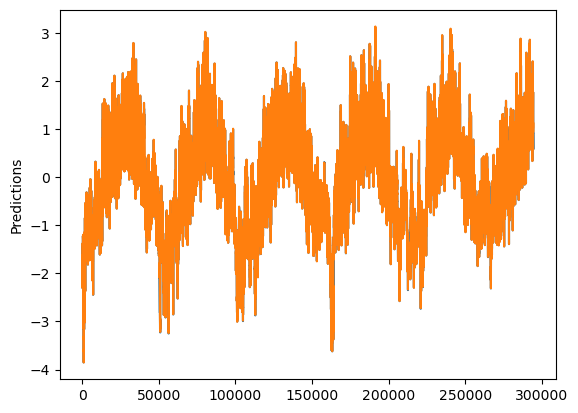

In [98]:
sns.lineplot(data = model4_pred_df["Predictions"])
sns.lineplot(data = model4_pred_df["Actual"])
plt.show()